In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from sipbuild.generator.parser.tokens import ambiguous

In [2]:
# Variables
keep_cols = {
    'Datum von': 'datetime',
    'Erdgas [MWh] Originalauflösungen': 'fossile_gas',
    'Braunkohle [MWh] Originalauflösungen': 'lignite',
    'Steinkohle [MWh] Originalauflösungen': 'hard_coal',
    'Sonstige Konventionelle [MWh] Originalauflösungen': 'other_conventionals'
}

In [3]:
# Preprocess Generation Data
## Read in generation data for each region
areas_df_dict = {
    'f_hertz': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_50Hertz_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    ),
    'amprion': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_Amprion_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    ),
    'tennet': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_TenneT_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    ),
    'transnet_bw': pd.read_csv(
        '../data/raw/smard/fileshare/market_data/Realisierte_Erzeugung_TransnetBW_202301010000_202501010000_Viertelstunde.csv',
        sep=';'
    )
}

## Convert regional generation data
for area, df in areas_df_dict.items():
    # Rename columns that will be kept
    df = df.rename(columns=keep_cols)

    # Only keep columns from keep_cols
    df = df.loc[:, [c for c in df.columns if c in keep_cols.values()]]

    # Transform date columns to datetime and set index
    df['datetime'] = pd.to_datetime(df['datetime'], format="%d.%m.%Y %H:%M")
    df = df.set_index('datetime')

    # Set timezone to UTC
    df.index = df.index.tz_localize('Europe/Berlin', ambiguous='infer')
    df.index = df.index.tz_convert('UTC')

    # Transform columns to numeric
    for col in df.columns:
        if not pd.api.types.is_float_dtype(df[col]):
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(".", "", regex=False)
                .str.replace(",", ".", regex=False)
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Aggregate conventional generation
    df['total_generation'] = df.sum(axis=1, numeric_only=True)

    areas_df_dict[area] = df

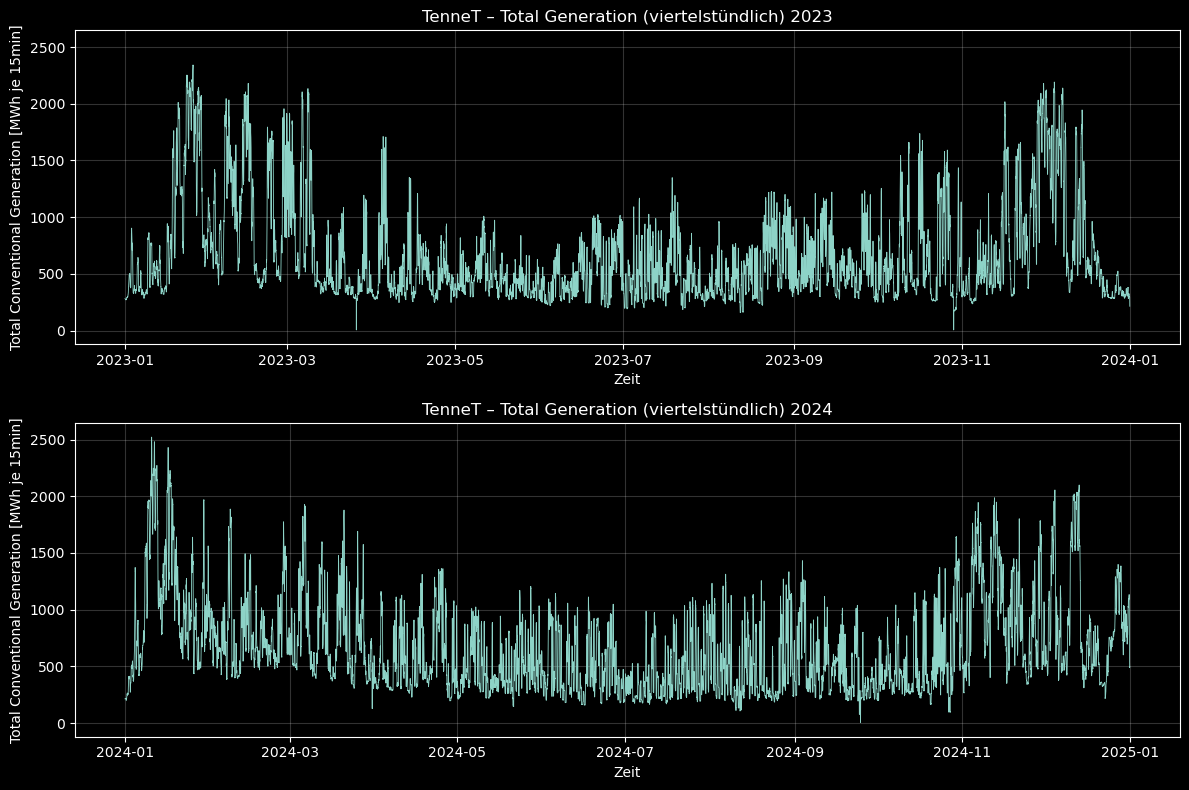

In [4]:
s = (
    areas_df_dict['tennet']['total_generation']
    .sort_index()
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharey=True)

for ax, year in zip(axes, [2023, 2024]):
    s_year = s[s.index.year == year]
    ax.plot(s_year.index, s_year.values, linewidth=0.6)
    ax.set_title(f"TenneT – Total Generation (viertelstündlich) {year}")
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Total Conventional Generation [MWh je 15min]")
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [5]:
# Preprocess Emissions Data
## Read in emissions data for each year and merge to one dataframe
emissions_2023 = pd.read_csv('../data/raw/agora/emissions_ger_2023_hourly.csv')
emissions_2024 = pd.read_csv('../data/raw/agora/emissions_ger_2024_hourly.csv')

## Concatenate both emissions dataframes
emissions = pd.concat([emissions_2023, emissions_2024])

## Rename columns
emissions = emissions.rename(columns={
    'Braunkohle': 'lignite',
    'Erdgas': 'fossile_gas',
    'Andere': 'other_conventionals',
    'Steinkohle': 'hard_coal',
    'Absolute Emissionen': 'total_emissions',
    'CO₂-Emissionsfaktor des Strommix': 'aef'
})

## Set index and timezone
emissions['Datetime'] = pd.to_datetime(emissions['Datetime'], format='%Y-%m-%dT%H:%M:%S')
emissions = emissions.set_index('Datetime')
try:
    emissions.index = emissions.index.tz_localize('Europe/Berlin', ambiguous='infer')
except pytz.exceptions.AmbiguousTimeError:
    emissions.index = emissions.index.tz_localize('Europe/Berlin', ambiguous=True)
emissions.index = emissions.index.tz_convert('UTC')

In [6]:
"""
Agora provides the data without considering the time shift from summer to winter time (no 2nd entry for 02:00), yet, it considers the shift
from winter to summer (01:00 -> 03:00). When transforming to UTC, the ambiguous=True forces pandas to interpret the entry 2023-10-29 02:00:00
as belonging to the summer time and thus sets it to 00:00 UTC. The entry 2023-10-29 03:00:00 is set to 02:00 UTC, thus leaving the 01:00 UTC
blank. To complete the time series, the gap is closed by performing a forward fill.
"""
start = pd.Timestamp("2023-10-28 23:00:00", tz="UTC")
end   = pd.Timestamp("2023-10-29 06:00:00", tz="UTC")
subset = emissions.loc[(emissions.index >= start) & (emissions.index < end)]
subset

,other_conventionals,lignite,hard_coal,fossile_gas,total_emissions,aef
Datetime,,,,,,
2023-10-28 23:00:00+00:00,2358.680,3686.148,1265.913,1678.103,8988.844,199.648
2023-10-29 00:00:00+00:00,2335.682,3824.804,1208.085,1704.349,9072.919,196.356
2023-10-29 02:00:00+00:00,2337.899,4257.758,1259.805,1731.046,9586.509,206.055
2023-10-29 03:00:00+00:00,2335.757,4231.726,1251.136,1746.612,9565.231,196.188
2023-10-29 04:00:00+00:00,2330.948,3961.540,1261.578,1799.373,9353.440,188.128
2023-10-29 05:00:00+00:00,2328.543,3693.273,1286.207,1803.265,9111.288,179.342


In [7]:
if emissions.duplicated().sum() >= 1:
    print(f"Duplicates at:\n  - {emissions[emissions.duplicated()].index}")
    try:
        emissions = emissions[~emissions.index.duplicated(keep='last')] # Only delete row when index is duplicated
        print("  - Duplicates deleted successfully.")
    except ValueError:
        print("  - Could not delete duplicates.")
print(f"Sum duplicates: {emissions.duplicated().sum()}")

Duplicates at:
  - DatetimeIndex(['2023-12-31 23:00:00+00:00'], dtype='datetime64[ns, UTC]', name='Datetime', freq=None)
  - Duplicates deleted successfully.
Sum duplicates: 0


In [8]:
## Closing the gap and removing duplicates
full_idx = pd.date_range(start=emissions.index.min(), end=emissions.index.max(), freq='h', tz='UTC')
emissions = emissions.reindex(full_idx)

emissions = emissions.interpolate(method='time', limit_direction='both')

## Double-check
subset = emissions.loc[(emissions.index >= start) & (emissions.index < end)]
subset

,other_conventionals,lignite,hard_coal,fossile_gas,total_emissions,aef
2023-10-28 23:00:00+00:00,2358.6800,3686.148,1265.913,1678.1030,8988.844,199.6480
2023-10-29 00:00:00+00:00,2335.6820,3824.804,1208.085,1704.3490,9072.919,196.3560
2023-10-29 01:00:00+00:00,2336.7905,4041.281,1233.945,1717.6975,9329.714,201.2055
2023-10-29 02:00:00+00:00,2337.8990,4257.758,1259.805,1731.0460,9586.509,206.0550
2023-10-29 03:00:00+00:00,2335.7570,4231.726,1251.136,1746.6120,9565.231,196.1880
2023-10-29 04:00:00+00:00,2330.9480,3961.540,1261.578,1799.3730,9353.440,188.1280
2023-10-29 05:00:00+00:00,2328.5430,3693.273,1286.207,1803.2650,9111.288,179.3420


In [9]:
"""
The generation timeseries consists of intervals such that the interval of time t contains [t, t+15)
The emissions timeseries consists of single points in time where at time t contains [t-60, t)
To align both, move emissions time series -1h such that t contains [t, t+60)
By forward filling, both time series can now be aligned, such that for emissions also t contains [t, t+15)
=> In the following, it is possible to:
    --> Compute the hourly emissions per control area, weighed by their share of conventional generation
    --> Perform a generation weighed downsampling of emissions to quarter hourly resolution
"""

# Align timeseries to period-start
emissions.index = emissions.index - pd.Timedelta(hours=1)
print(emissions.index[0]) # Should be 2022-12-31 23:00:00

2022-12-31 22:00:00+00:00


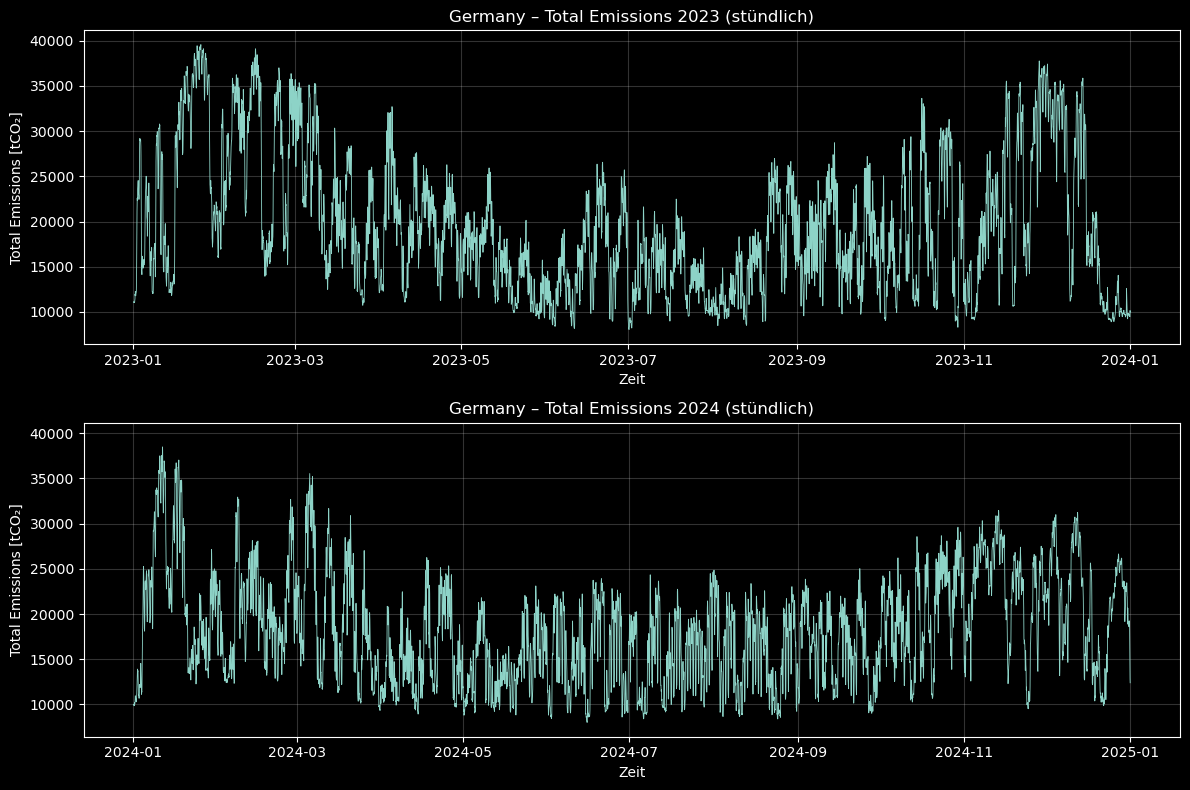

In [10]:
import matplotlib.pyplot as plt

e = emissions["total_emissions"].sort_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharey=True)

for ax, year in zip(axes, [2023, 2024]):
    e_year = e[e.index.year == year]
    ax.plot(e_year.index, e_year.values, linewidth=0.6)
    ax.set_title(f"Germany – Total Emissions {year} (stündlich)")
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Total Emissions [tCO₂]")  # falls Einheit anders ist: Label anpassen
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [11]:
# Save dataframes to a file

for area in areas_df_dict:
    min_date = areas_df_dict[area].index.min().strftime('%Y%m%d%H%M')
    max_date = areas_df_dict[area].index.max().strftime('%Y%m%d%H%M')
    areas_df_dict[area].to_csv(f'../data/interim/generation_{area}_utc_{min_date}_{max_date}.csv')

min_date = emissions.index.min().strftime('%Y%m%d%H%M')
max_date = emissions.index.max().strftime('%Y%m%d%H%M')
emissions.to_csv(f'../data/interim/emissions_germany_utc_{min_date}_{max_date}.csv', index=True)